# Определение перспективного тарифа для телеком-компании

В моем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше. Моя задачи — обработать данные и привести их в нужный для анализа вид, сравнить выручку в разрезе по региону пользователя, по тарифу, оценить вероятность сравнительно одинаковой выручки от тарифов.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Изучение-данных-из-файла" data-toc-modified-id="Изучение-данных-из-файла-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Изучение данных из файла</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Подготовка данных" data-toc-modified-id="Подготовка данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ данных." data-toc-modified-id="Анализ данных.-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ данных.</a></span></li><li><span><a href="#Проверка гипотез." data-toc-modified-id="Проверка гипотез.-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка гипотез.</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a

##  Изучение данных из файла.

In [1]:
#импортируем пандас, изучаем данные
from scipy import stats as st
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from functools import reduce
from scipy.stats import levene
import seaborn as sns
dc = pd.read_csv('/datasets/calls.csv')
dc.info()
dc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [2]:
di = pd.read_csv('/datasets/internet.csv')
di.info()
di.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [3]:
dm = pd.read_csv('/datasets/messages.csv')
dm.info()
dm.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [4]:
dt = pd.read_csv('/datasets/tariffs.csv')
dt.info()
dt.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [5]:
du = pd.read_csv('/datasets/users.csv')
du.info()
du.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Вывод: Нужно объединить 5 таблиц в одну по user_id и тарифу (нужно переименовать в одной таблице столбец tariff_name в tariff). Добавить столбец месяц.

## . Подготовка данных

In [6]:
# добавление столбца месяц
dc['call_date'] = pd.to_datetime(dc['call_date'], format='%Y-%m-%d')
dc['month'] = dc['call_date'].dt.month

In [8]:
# окргуление минут в сторону увеличения

dc['duration'] = np.ceil(dc['duration'])
dc.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.0,1000,7
1,1000_1,2018-08-17,0.0,1000,8
2,1000_2,2018-06-11,3.0,1000,6
3,1000_3,2018-09-21,14.0,1000,9
4,1000_4,2018-12-15,6.0,1000,12


In [9]:
# группировка по пользователю и месяцу с расчетом общей длительностьи звонков

dc = dc.rename(columns = {'call_date' : 'date'})
dc = dc.groupby(['user_id', 'month']).agg({'duration': 'sum'}).reset_index()
dc.head()

,user_id,month,duration
0,1000,5,159.0
1,1000,6,172.0
2,1000,7,340.0
3,1000,8,408.0
4,1000,9,466.0


In [10]:
#добавление столбца месяц
di['session_date'] = pd.to_datetime(di['session_date'], format='%Y-%m-%d')
di['month'] = di['session_date'].dt.month
di = di.rename(columns = {'session_date' : 'date'})
di['date'] = di['date'].astype('datetime64[M]')

In [11]:
# группировка по пользователю и месяцу с расчетом общего объема трафика по месяцу
di = di.groupby(['user_id', 'month']).agg({'mb_used': 'sum'}).reset_index()
di.head()

,user_id,month,mb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91


In [12]:
# Добавление столбца гигабайты
di['gb_used'] = di['mb_used']/1024
di['gb_used'] = di['gb_used'].apply(np.ceil)
di.head()

,user_id,month,mb_used,gb_used
0,1000,5,2253.49,3.0
1,1000,6,23233.77,23.0
2,1000,7,14003.64,14.0
3,1000,8,14055.93,14.0
4,1000,9,14568.91,15.0


In [13]:
#добавление столбца месяц 
dm['message_date'] = pd.to_datetime(dm['message_date'], format='%Y-%m-%d')
dm['month'] = dm['message_date'].dt.month
dm = dm.rename(columns = {'message_date' : 'date'})
dm['date'] = dm['date'].astype('datetime64[M]')
dm.head()

,id,date,user_id,month
0,1000_0,2018-06-01,1000,6
1,1000_1,2018-10-01,1000,10
2,1000_2,2018-08-01,1000,8
3,1000_3,2018-06-01,1000,6
4,1000_4,2018-12-01,1000,12


In [14]:
# группировка по пользователю и месяцу с расчетом общего количества смс
dm = dm.groupby(['user_id', 'month']).agg({'id': 'count'}).reset_index()
dm.head()

,user_id,month,id
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


In [15]:
# переименование столбца по причине разности названий столцов tarif и tariff_name
dt = dt.rename(columns = {'tariff_name' : 'tariff'})



### Объединение таблиц

In [16]:
# объединяем звонки и интернет 
data = dc.merge(di, on = ['user_id', 'month'], how = 'outer')
data.head()

,user_id,month,duration,mb_used,gb_used
0,1000,5,159.0,2253.49,3.0
1,1000,6,172.0,23233.77,23.0
2,1000,7,340.0,14003.64,14.0
3,1000,8,408.0,14055.93,14.0
4,1000,9,466.0,14568.91,15.0


In [17]:
# добавляем смски
data_2 = data.merge(dm, on = ['user_id', 'month'], how = 'outer')
data_2.head()

,user_id,month,duration,mb_used,gb_used,id
0,1000,5,159.0,2253.49,3.0,22.0
1,1000,6,172.0,23233.77,23.0,60.0
2,1000,7,340.0,14003.64,14.0,75.0
3,1000,8,408.0,14055.93,14.0,81.0
4,1000,9,466.0,14568.91,15.0,57.0


In [18]:
# добавляем пользователей
data_3 = data_2.merge(du, on = ['user_id'], how = 'outer')
data_3.head()

,user_id,month,duration,mb_used,gb_used,id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5.0,159.0,2253.49,3.0,22.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6.0,172.0,23233.77,23.0,60.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7.0,340.0,14003.64,14.0,75.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8.0,408.0,14055.93,14.0,81.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9.0,466.0,14568.91,15.0,57.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


In [19]:
# добавляем тариф
data_total = data_3.merge(dt, on = ['tariff'], how = 'outer')
data_total.head(10)

,user_id,month,duration,mb_used,gb_used,id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5.0,159.0,2253.49,3.0,22.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6.0,172.0,23233.77,23.0,60.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7.0,340.0,14003.64,14.0,75.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8.0,408.0,14055.93,14.0,81.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9.0,466.0,14568.91,15.0,57.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
5,1000,10.0,350.0,14702.49,15.0,73.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
6,1000,11.0,338.0,14756.47,15.0,58.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
7,1000,12.0,333.0,9817.61,10.0,70.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
8,1003,8.0,380.0,8565.21,9.0,37.0,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,1000,30720,3000,1950,150,1,1
9,1003,9.0,961.0,12468.87,13.0,91.0,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,1000,30720,3000,1950,150,1,1


In [22]:
# функция для расчета выручки от звонков и добавление столбца
def profit(row):
    if row['duration'] > row['minutes_included']: return (row['duration'] - row['minutes_included'])*row['rub_per_minute']
    return 0
data_total['profit_call'] = data_total.apply(profit, axis = 1)
data_total.head()

,user_id,month,duration,mb_used,gb_used,id,age,churn_date,city,first_name,...,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,profit_call
0,1000,5.0,159.0,2253.49,3.0,22.0,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.0
1,1000,6.0,172.0,23233.77,23.0,60.0,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.0
2,1000,7.0,340.0,14003.64,14.0,75.0,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.0
3,1000,8.0,408.0,14055.93,14.0,81.0,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.0
4,1000,9.0,466.0,14568.91,15.0,57.0,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.0


In [23]:
# функция для расчета выручки от интернета и добавление столбца
def profit_2(row):
    if row['gb_used'] > (row['mb_per_month_included']/1024): return (row['gb_used'] - (row['mb_per_month_included']/1024))*row['rub_per_gb']
    return 0
data_total['profit_internet'] = data_total.apply(profit_2, axis = 1)
data_total.head()

,user_id,month,duration,mb_used,gb_used,id,age,churn_date,city,first_name,...,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,profit_call,profit_internet
0,1000,5.0,159.0,2253.49,3.0,22.0,52,NaN,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0
1,1000,6.0,172.0,23233.77,23.0,60.0,52,NaN,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0
2,1000,7.0,340.0,14003.64,14.0,75.0,52,NaN,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0
3,1000,8.0,408.0,14055.93,14.0,81.0,52,NaN,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0
4,1000,9.0,466.0,14568.91,15.0,57.0,52,NaN,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0


In [24]:
# функция для расчета выручки от смс и добавление столбца
def profit_3(row):
    if row['id'] > row['messages_included']: return (row['id'] - row['messages_included'])*row['rub_per_message']
    return 0
data_total['profit_message'] = data_total.apply(profit_3, axis = 1)
pd.set_option('display.max_columns', None)
data_total.head()

,user_id,month,duration,mb_used,gb_used,id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,profit_call,profit_internet,profit_message
0,1000,5.0,159.0,2253.49,3.0,22.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0
1,1000,6.0,172.0,23233.77,23.0,60.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0
2,1000,7.0,340.0,14003.64,14.0,75.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0
3,1000,8.0,408.0,14055.93,14.0,81.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0
4,1000,9.0,466.0,14568.91,15.0,57.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0


In [25]:
# добавляем столбец общий доход
data_total['total_profit'] = data_total['profit_call'] + data_total['profit_internet'] + data_total['profit_message'] + data_total['rub_monthly_fee']

Вывод: Объединили все данные в одну таблицу. Рассчитали общий объем смс, интернета, звонков по месяцам и по пользователям.

## Анализ данных.

In [26]:
# считаем максимум и минимум диаграммы размаха указанных столбцов
columns_to_quantile = ['duration', 'gb_used', 'id'] 
for element in columns_to_quantile:
    q1 = data_total[element].quantile(0.25)
    q3 = data_total[element].quantile(0.75)
    iqr = q3 - q1 
    first = q1 - 1.5 * iqr
    last = q3 + 1.5 * iqr# iqr
# границы интервала наиболее вероятных значений
    print(element)
    print(first, last)

duration
-163.0 1045.0
gb_used
1.0 33.0
id
-47.0 129.0


In [27]:
# считаем среднее, стандартное отклонение и дисперсию. До кучи сумму и медиану.
data_total.groupby('tariff').agg({'duration': ['mean', 'std', 'var', 'count', 'median']})

duration                                       
              mean         std           var count median
tariff                                                   
smart   419.062978  189.325618  35844.189551  2223  423.0
ultra   545.451104  306.925754  94203.418396   951  528.0

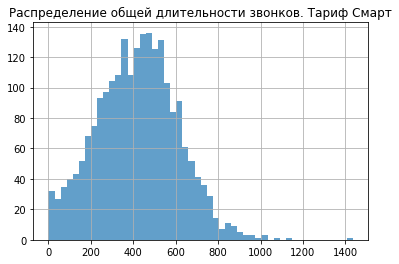

In [28]:
# строим гистограмму распределения звонков
smart = data_total.query('tariff == "smart"')
smart['duration'].hist(bins = 50, alpha=0.7)
plt.title('Распределение общей длительности звонков. Тариф Смарт');

In [ ]:
# построили диаграмму размаха
smart['duration'].plot.box(grid = True, figsize =(10,10))
plt.title('Диаграмма размаха общая длительность звонков');

Нормальное распределение с небольшим количеством выбросов. Большая часть пользователей тарифа Смарт укладывается в положенные в тариф количество минут.

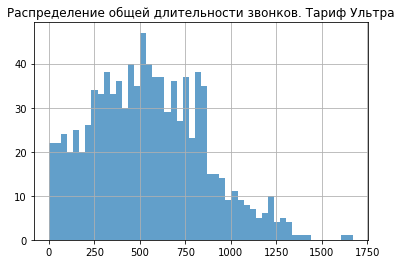

In [30]:
# строим гистограмму распределения звонков
ultra = data_total.query('tariff == "ultra"')
ultra['duration'].hist(bins=50, alpha=0.7)
plt.title('Распределение общей длительности звонков. Тариф Ультра');

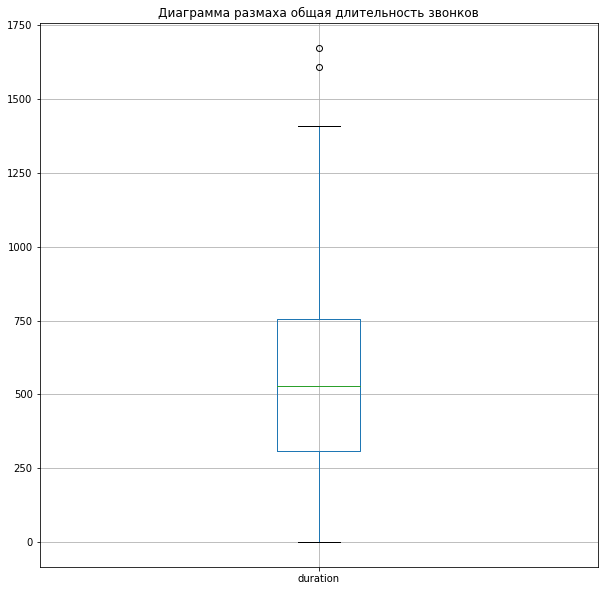

In [31]:
# построили диаграмму размаха
ultra['duration'].plot.box(grid = True, figsize =(10,10))
plt.title('Диаграмма размаха общая длительность звонков');

Норму звонков не выбирает никто, следовательно заработать на дополнительных минутах с высокой долей вероятности не выйдет.

In [32]:
# считаем среднее, стандартное отклонение и дисперсию
data_total.groupby('tariff').agg({'gb_used': ['mean', 'std', 'var', 'count', 'median']})

gb_used                                  
             mean       std        var count median
tariff                                             
smart   16.336176  5.737923  32.923756  2228   17.0
ultra   19.694359  9.702924  94.146734   975   19.0

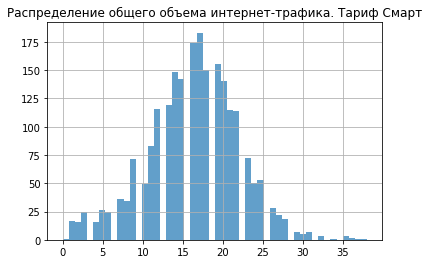

In [33]:
# строим гистограмму распределения интернета
smart_2 = data_total.query('tariff == "smart"')
smart_2['gb_used'].hist(bins = 50, alpha=0.7)
plt.title('Распределение общего объема интернет-трафика. Тариф Смарт');

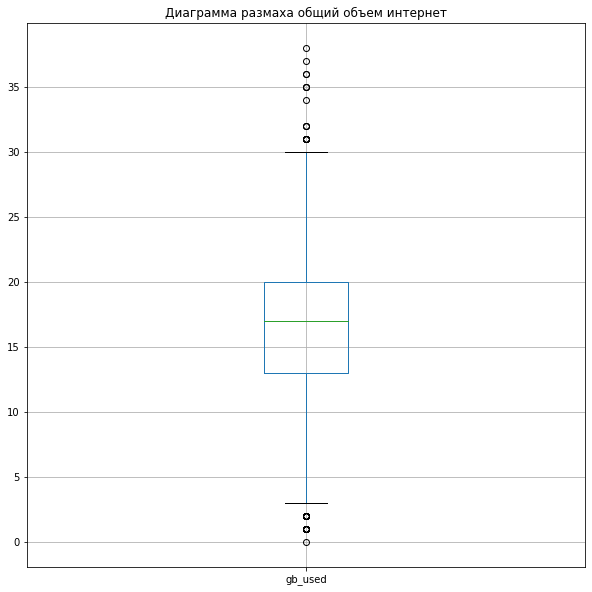

In [34]:
# построили диаграмму размаха
smart_2['gb_used'].plot.box(grid = True, figsize =(10,10))
plt.title('Диаграмма размаха общий объем интернет');

Типичное нормальное распределение в виде колокола. Пользователи тарифа Смарт разделились где-то 45 на 55 как уклаыдвающиеся в тарифный объем интернета и как не укладывающиеся.

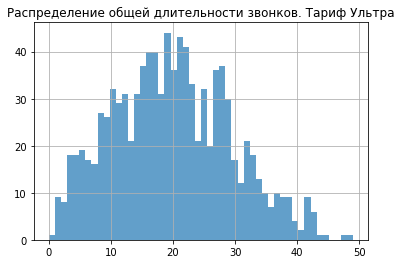

In [35]:
# строим гистограмму распределения интернета
ultra_2 = data_total.query('tariff == "ultra"')
ultra_2['gb_used'].hist(bins=50, alpha=0.7)
plt.title('Распределение общей длительности звонков. Тариф Ультра');

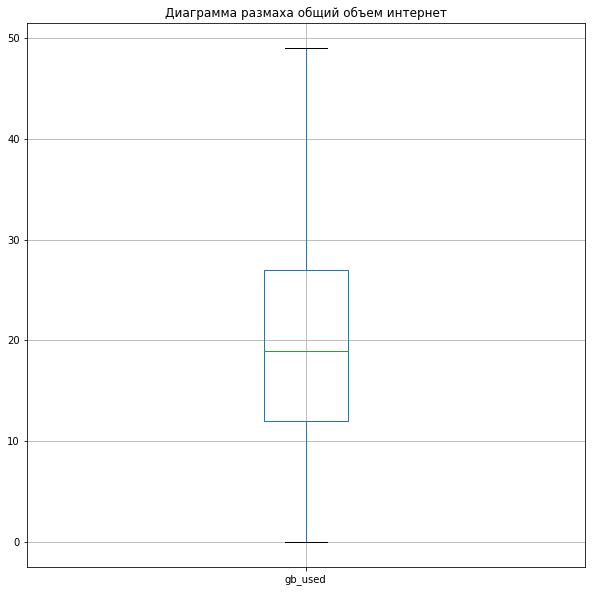

In [36]:
# построили диаграмму размаха
ultra_2['gb_used'].plot.box(grid = True, figsize =(10,10))
plt.title('Диаграмма размаха общий объем интернет');

Большинство пользователей укладывается в положенные тарифом гигабайты, но есть немаленькая доля кто превышает.

In [37]:
# считаем среднее, стандартное отклонение и дисперсию
data_total.groupby('tariff').agg({'id': ['mean', 'std', 'var', 'count', 'median']})

id                                     
             mean        std          var count median
tariff                                                
smart   38.716441  26.787949   717.594201  1922   34.0
ultra   61.161006  45.931026  2109.659183   795   51.0

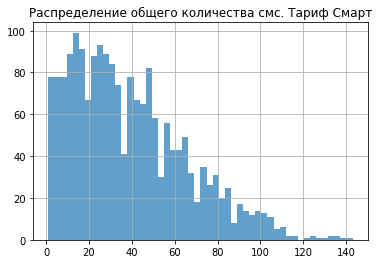

In [38]:
# строим гистограмму распределения смс
smart_3 = data_total.query('tariff == "smart"')
smart_3['id'].hist(bins = 50, alpha=0.7)
plt.title('Распределение общего количества смс. Тариф Смарт');

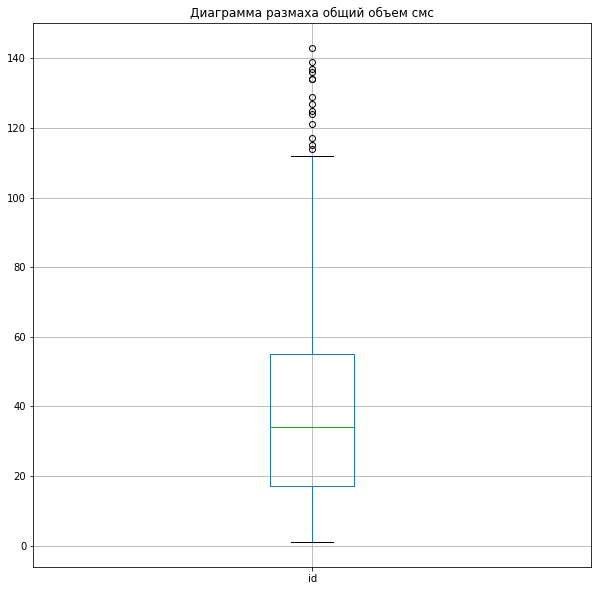

In [39]:
# построили диаграмму размаха
smart_3['id'].plot.box(grid = True, figsize =(10,10))
plt.title('Диаграмма размаха общий объем смс');

Нормальное распределение со сдвигом влево. Небольшая доля польователей пользуется доп. смсками.

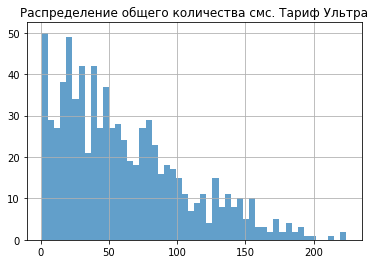

In [40]:
# строим гистограмму распределения смс
ultra_3 = data_total.query('tariff == "ultra"')
ultra_3['id'].hist(bins=50, alpha=0.7)
plt.title('Распределение общего количества смс. Тариф Ультра');

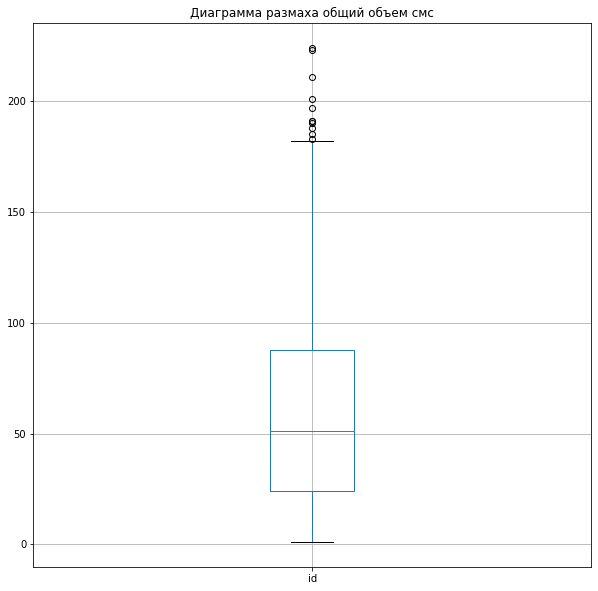

In [41]:
# построили диаграмму размаха
ultra_3['id'].plot.box(grid = True, figsize =(10,10))
plt.title('Диаграмма размаха общий объем смс');

С смс история аналогичная звонкам. Доп. смс никто не пользуется.

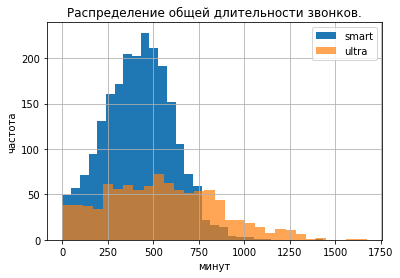

In [42]:
ax=data_total[data_total['tariff']=='smart']['duration'].hist(bins=30)
data_total[data_total['tariff']=='ultra']['duration'].hist(bins=30, alpha=0.7)
plt.title('Распределение общей длительности звонков.')
plt.xlabel('минут')
plt.ylabel('частота')
plt.legend(['smart', 'ultra'])
plt.show()

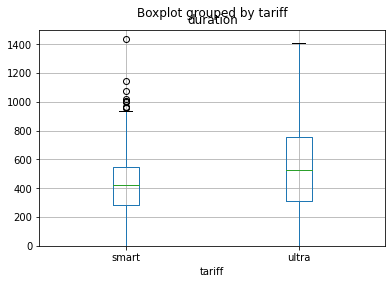

In [43]:
data_total.boxplot(column='duration', by='tariff')
plt.ylim(0, 1500);

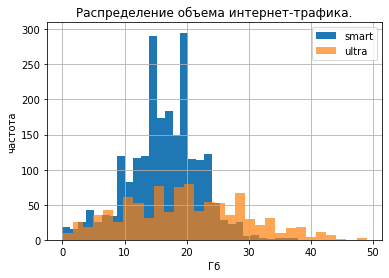

In [44]:
ax=data_total[data_total['tariff']=='smart']['gb_used'].hist(bins=30)
data_total[data_total['tariff']=='ultra']['gb_used'].hist(bins=30, alpha=0.7)
plt.title('Распределение объема интернет-трафика.')
plt.xlabel('Гб')
plt.ylabel('частота')
plt.legend(['smart', 'ultra'])
plt.show()

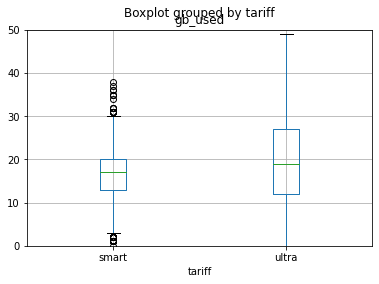

In [45]:
data_total.boxplot(column='gb_used', by='tariff')
plt.ylim(0, 50);

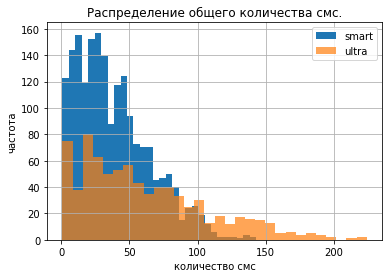

In [46]:
ax=data_total[data_total['tariff']=='smart']['id'].hist(bins=30)
data_total[data_total['tariff']=='ultra']['id'].hist(bins=30, alpha=0.7)
plt.title('Распределение общего количества смс.')
plt.xlabel('количество смс')
plt.ylabel('частота')
plt.legend(['smart', 'ultra'])
plt.show()

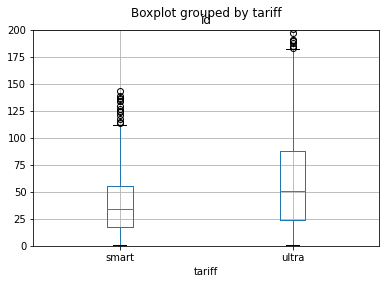

In [47]:
data_total.boxplot(column='id', by='tariff')
plt.ylim(0, 200);

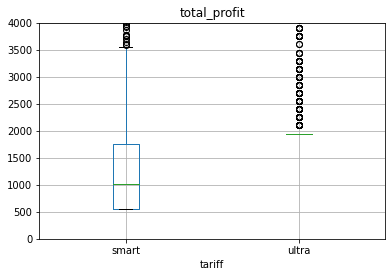

In [51]:
#Строим диаграммы размаха для столбца тариф
import warnings
warnings.filterwarnings('ignore')
data_total.boxplot(column='total_profit', by='tariff')
plt.suptitle('')
plt.ylim(0, 4000);

Все значения выручки которые укладываются в диаграмму размаха по тарифу Ультра явяляются медианой, то есть ежемесячной платой а тариф. Следовательно доп. выручка от превышения в общей массе незначительна и явялется выбросами.
По тарифу Смарт можно сказать, что за стоимоcть тарифа выходят практически все, поскольку 2 квантиль примерно равен 550 рублям тарифа, следовательно все остальные выше указанной суммы. Однако медиана свидетельствует о том, что все таки выручка от тарифа Смарт меньше выручки от тарифа Ультра.

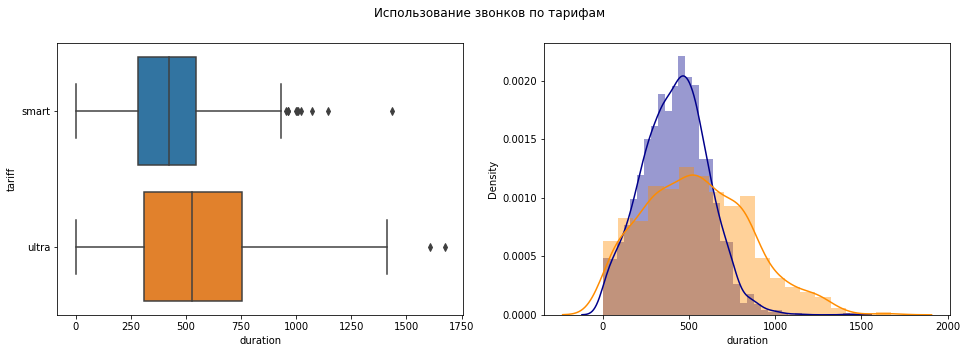

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.boxplot(data=data_total.sort_values(by='tariff'), x='duration', y='tariff', ax=axes[0])

sns.distplot(data_total.query('tariff == "smart"')['duration'], color='darkblue', ax=axes[1])
sns.distplot(data_total.query('tariff == "ultra"')['duration'], color='darkorange', ax=axes[1])

fig.suptitle('Использование звонков по тарифам')

plt.show();


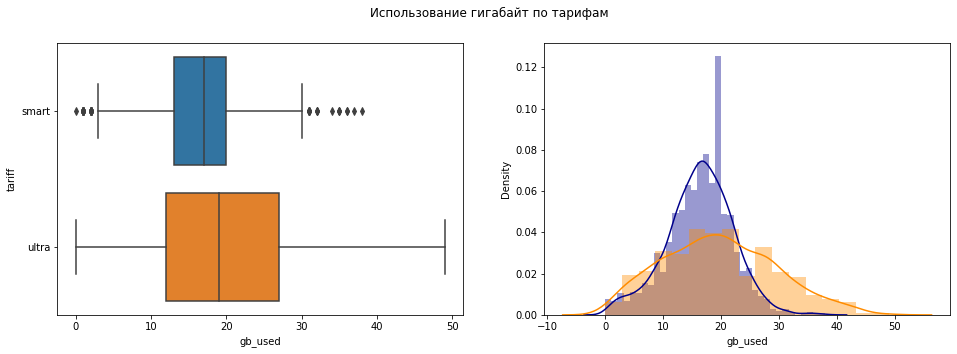

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.boxplot(data=data_total.sort_values(by='tariff'), x='gb_used', y='tariff', ax=axes[0])

sns.distplot(data_total.query('tariff == "smart"')['gb_used'], color='darkblue', ax=axes[1])
sns.distplot(data_total.query('tariff == "ultra"')['gb_used'], color='darkorange', ax=axes[1])

fig.suptitle('Использование гигабайт по тарифам')

plt.show();


In [53]:
data_total

,user_id,month,duration,mb_used,gb_used,id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,profit_call,profit_internet,profit_message,total_profit
0,1000,5.0,159.0,2253.49,3.0,22.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
1,1000,6.0,172.0,23233.77,23.0,60.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
2,1000,7.0,340.0,14003.64,14.0,75.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
3,1000,8.0,408.0,14055.93,14.0,81.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
4,1000,9.0,466.0,14568.91,15.0,57.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1489,9.0,NaN,17206.30,17.0,32.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,0.0,400.0,0.0,950.0
3212,1489,10.0,NaN,19559.44,20.0,21.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,0.0,1000.0,0.0,1550.0
3213,1489,11.0,NaN,17491.56,18.0,20.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,0.0,600.0,0.0,1150.0
3214,1489,12.0,NaN,17322.51,17.0,35.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,0.0,400.0,0.0,950.0


## Проверка гипотез.

Нулевая гипотеза - считаем, что средняя выручка пользователей тарифов «Ультра» и «Смарт» приблизительно одинаковы. Альтернативная гипотеза - обратна нулевой гипотезе.

In [59]:
smart_profit = data_total.query('tariff == "smart"')
variance_estimate_1 = np.var(smart_profit['total_profit'])
smart_profit_od = smart_profit['total_profit']
ultra_profit = data_total.query('tariff == "ultra"')
variance_estimate_2 = np.var(ultra_profit['total_profit'])
ultra_profit_od = ultra_profit['total_profit']
print(variance_estimate_1)
print(variance_estimate_2)
alpha = 0.05  # критический уровень статистической значимости

#results = st.ttest_1samp(smart_profit_od, ultra_profit_od)
results = st.ttest_ind(smart_profit_od, ultra_profit_od)
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

669430.4361979931
141244.31956107615
p-значение:  8.081909555489933e-161
Отвергаем нулевую гипотезу


In [60]:
# Тест Левена для оценки равенства дисперсии между двумя разными выборками
stat, p = levene(smart_profit['total_profit'], ultra_profit['total_profit'])

p

2.3578651290079928e-122

Полученное значение p-value говорит о том, что получить схожую среднюю выручку по тарифам практически невозможно, настолько малая вероятность.

Нулевая гипотеза - считаем, что средняя выручка пользователей Москвы и других регионов приблизительно одинаковы. Альтернативная гипотеза - обратна нулевой гипотезе.

In [61]:
msk_profit = data_total.query('city == "Москва"')
variance_estimate_1 = np.var(msk_profit['total_profit'], ddof=1)
msk_profit_od = msk_profit['total_profit']
other_profit = data_total.query('city != "Москва"')
variance_estimate_2 = np.var(other_profit['total_profit'], ddof=1)
other_profit_od = other_profit['total_profit']
print(variance_estimate_1)
print(variance_estimate_2)

alpha = 0.05  # критический уровень статистической значимости

#results = st.ttest_1samp(msk_profit_od, other_profit_od)
results = st.ttest_ind(msk_profit_od, other_profit_od)
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

565636.467011886
654069.574962777
p-значение:  0.5400751614511182
Не получилось отвергнуть нулевую гипотезу


In [62]:
# Тест Левена для оценки равенства дисперсии между двумя разными выборками
stat, p = levene(smart_profit['total_profit'], ultra_profit['total_profit'])

p

2.3578651290079928e-122

Полученное значение p-value говорит о том, что есть высокая вероятность получить среднюю выручку по пользователям в Москве и пользователям других регионов.

## Общий вывод.

Тариф Смарт. 
Большая часть пользователей тарифа  укладывается в положенные в тариф количество минут. Немалая доля пользователей пользуется доп. минутами.
Пользователи тарифа разделились где-то 45 на 55 как уклаыдвающиеся в тарифный объем интернета и как не укладывающиеся.
Небольшая доля пользователей пользуется доп. смсками.

Тариф Ультра.
Большинство пользователей укладывается в положенные тарифом гигабайты, но есть немаленькая доля кто превышает.
Норму звонков не выбирает никто, следовательно заработать на дополнительных минутах с высокой долей вероятности не выйдет.
С смс история аналогичная звонкам. Доп. смс никто не пользуется.

Подавляющее большинство пользователей тарифа Ультра приносят выручку в размере платы за тариф. Следовательно доп. выручка от превышения в общей массе незначительна.
По тарифу Смарт можно сказать, что за стоимоcть тарифа выходят практически все, тем не менее выручка в среднем от тарифа Смарт меньше выручки от тарифа Ультра.

Тариф Смарт позволяет с высокой долей вероятности получить дополнительную прибыль за дополнительные пакеты звонков, смс и интернета. Однако тариф Ультра безусловно предпочтительнее с точки зрения выручки. Весьма вероятно стоит уменьшить объем пакетов включенных в тариф с целью дополнительной выручки :). Проверкой гипотез выяснилось, что добиться схожей выручки по тарифам маловероятно. Также маловероятно получить отличную выручку между пользователями Москвы и других регионов практически нет.